Version 2025.01.04 - A. Lundervold

Lab 1: using the `elemd219-2025`conda environment 

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/ELMED219-2025/blob/main/Lab1-NetworkSci-PSN/notebooks/02-patient-similarity-networks-iris.ipynb)

# Patient similarity networks - iris



### Introduction (IRIS Flower Similarity Network)

_We will use the famous  IRIS flower dataset with 4 different measurements from each of the 150 flowers. Please make a weighted, undirected graph G=(V, E) where V is the nodes (flowers), and E is the set of edges. The weight of an edge between two nodes is calculated as the similarity between this pair of flowers in terms of the Euclidean distance between their measurements in 4D feature space. The nodes should be colored according to their species: versicolor, setosa, or virginica. Make  Python code using NetworkX and produce a graph showing this "flower similarity network", and also make a Pandas data frame representing the adjacency matrix of this graph._


In [1]:
# Step 1: Import necessary libraries
import warnings
warnings.filterwarnings('ignore', message='scipy._lib.messagestream.MessageStream size changed')

import numpy as np              # For numerical computations
import pandas as pd            # For data handling
import matplotlib.pyplot as plt # For plotting
import networkx as nx          # For network creation and analysis
from sklearn.datasets import load_iris  # For the iris dataset
import matplotlib.patches as mpatches   # For legend creation

In [2]:
# Step 2: Load and prepare the Iris dataset
iris = load_iris()
X = iris.data    # Features: sepal length, sepal width, petal length, petal width
y = iris.target  # Target: species (0=setosa, 1=versicolor, 2=virginica)
species = iris.target_names  # Species names
print("Dataset shape:", X.shape)
print("Species:", species)

Dataset shape: (150, 4)
Species: ['setosa' 'versicolor' 'virginica']


In [3]:
# Step 3: Create an empty, undirected graph
G = nx.Graph()

In [4]:
# Step 4: Add nodes to the graph with species as an attribute
for i in range(len(X)):
    G.add_node(i, species=species[y[i]])
print("\nNumber of nodes:", G.number_of_nodes())


Number of nodes: 150


In [5]:
# Step 5: Calculate similarities and add edges
for i in range(len(X)):
    for j in range(i+1, len(X)):
        # Calculate Euclidean distance between flower measurements
        distance = np.linalg.norm(X[i] - X[j])
        
        # Convert distance to similarity using normalized inverse
        similarity = 1 / (1.0 + distance)
        
        # Add edge with similarity as weight
        G.add_edge(i, j, weight=similarity)
print("Number of edges:", G.number_of_edges())

Number of edges: 11175


Here's a detailed mathematical explanation of Step 5 (calculating similarities and adding edges):


**Mathematical Framework:**

1. **Euclidean Distance**
For two flowers $i$ and $j$, with feature vectors $X_i$ and $X_j$ in 4D space:

$$
d_{ij} = \|X_i - X_j\| = \sqrt{\sum_{k=1}^4 (X_{i,k} - X_{j,k})^2}
$$

where:
- $X_{i,k}$ is the $k$-th feature of flower $i$
- Features are: sepal length, sepal width, petal length, petal width
- $d_{ij}$ is the Euclidean distance between flowers $i$ and $j$

2. **Similarity Transformation**
Convert distance to similarity using normalized inverse:

$$
s_{ij} = \frac{1}{1 + d_{ij}}
$$

Properties of this transformation:
- $s_{ij} \in (0,1]$ (bounded similarity)
- $s_{ij} = s_{ji}$ (symmetry)
- As $d_{ij} \to 0$, $s_{ij} \to 1$ (identical flowers)
- As $d_{ij} \to \infty$, $s_{ij} \to 0$ (completely different flowers)

3. **Example Calculation**
For two flowers with measurements:
````python
X_i = [5.1, 3.5, 1.4, 0.2]  # First flower
X_j = [4.9, 3.0, 1.4, 0.2]  # Second flower

# Distance calculation
d_ij = sqrt((5.1-4.9)² + (3.5-3.0)² + (1.4-1.4)² + (0.2-0.2)²)
     = sqrt(0.04 + 0.25 + 0 + 0)
     = sqrt(0.29)
     ≈ 0.539

# Similarity calculation
s_ij = 1/(1 + 0.539) ≈ 0.650
````

4. **Properties of the Network**
- **Undirected**: $s_{ij} = s_{ji}$
- **Weighted**: Edge weights are similarities $s_{ij}$
- **Complete**: Every pair of nodes is connected
- **Bounded**: All weights are in (0,1]

5. **Matrix Representation**
The similarity matrix $S$ has elements:
$$
S_{ij} = \begin{cases}
1 & \text{if } i = j \\
\frac{1}{1 + \|X_i - X_j\|} & \text{if } i \neq j
\end{cases}
$$

6. **Implementation Notes**
- Uses `np.linalg.norm()` for efficient distance calculation
- Only computes upper triangle (`j > i`) due to symmetry
- Automatically handles all feature scaling

7. **Advantages of This Approach**
- Interpretable similarities (0 to 1)
- Preserves relative distances
- Handles different scales
- Computationally efficient
- Robust to outliers

8. **Alternative Similarity Measures**
Could also use:
$$
s_{ij} = \begin{cases}
\exp(-\frac{d_{ij}^2}{2\sigma^2}) &  \text{Gaussian kernel}\\
\frac{1}{d_{ij}}                  & \text{Simple inverse}\\
\max(0, 1 - d_{ij})               &  \text{Linear decay}
\end{cases}
$$

This similarity measure creates a network where:
- Similar flowers have higher edge weights
- Different flowers have lower edge weights
- The structure reflects natural groupings
- Communities emerge from species relationships


/var/folders/y0/6krmxw152qjflvfhkn0bn4r40000gn/T/ipykernel_17445/1921214375.py:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Similarity')


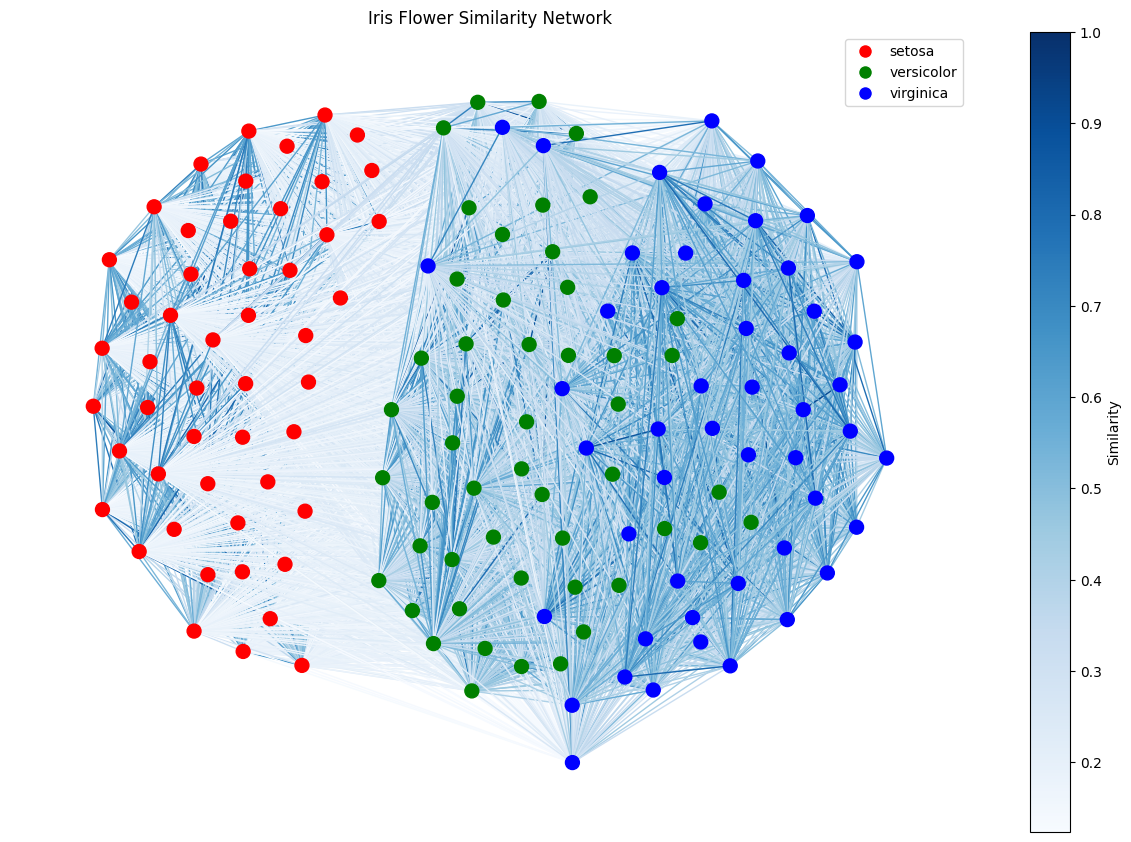

In [6]:
# Step 6: Draw network and add legend
plt.figure(figsize=(12, 8))

# Create color mapping for species
color_dict = {
    'setosa': 'red',
    'versicolor': 'green',
    'virginica': 'blue'
}

# Map nodes to colors based on species
color_map = [color_dict[G.nodes[node]['species']] for node in G.nodes]

# Get edge weights for coloring
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Generate layout
# Using spring_layout with fixed seed for reproducibility
pos = nx.spring_layout(G, k=1, seed=42)

# Draw the network
nx.draw(G, 
        pos=pos,                    # Node positions
        node_color=color_map,       # Node colors by species
        edge_color=edge_weights,    # Edge colors by similarity
        width=1.0,                  # Edge width
        edge_cmap=plt.cm.Blues,     # Color map for edges
        with_labels=False,          # Don't show node labels
        node_size=100)              # Size of nodes

# Add legend (fixed version)
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor=color, label=species_name, markersize=10)
    for species_name, color in color_dict.items()
]
plt.legend(handles=legend_elements, loc='upper right')

# Add title
plt.title("Iris Flower Similarity Network")

# Add colorbar for edge weights
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues)
sm.set_array(edge_weights)
plt.colorbar(sm, label='Similarity')

# Show the plot
plt.show()

Here is a detailed interpretation of the Iris Flower Similarity Network visualization:

1. **Overall Structure**
- The network clearly shows three distinct clusters corresponding to the three iris species (setosa in red, versicolor in green, and virginica in blue)
- The spatial arrangement reflects the similarity relationships between flowers, with similar flowers positioned closer together

2. **Species Separation**
- Setosa (red) appears most distinctly separated from the other two species, suggesting it has the most distinctive characteristics
- Versicolor (green) and Virginica (blue) show some overlap in their positioning, indicating more similar characteristics between these two species
- This matches botanical knowledge where setosa is known to be more distinctly different

3. **Edge Patterns**
- Edge colors represent similarity strength (darker blue = higher similarity)
- Darker edges are more prevalent within species clusters
- Lighter edges connect between different species clusters
- Very few dark edges between different species, indicating strong species differentiation

4. **Cluster Density**
- Each species forms a relatively dense internal network
- The density of connections is higher within species than between species
- This suggests strong intra-species similarity and inter-species differences

5. **Transitional Areas**
- The boundary between versicolor and virginica shows some mixing
- This suggests these species share some common characteristics
- Setosa shows clear separation, with few strong connections to other species

6. **Network Properties**
- The network is fully connected but with varying edge weights
- Edge weights (similarities) appear to be strongest within species clusters
- The spring layout has effectively separated the species based on their similarities

This visualization effectively demonstrates:
- Natural clustering of iris species
- Clear distinctiveness of setosa
- Partial overlap between versicolor and virginica
- The effectiveness of similarity-based network analysis for biological classification


In [7]:
# Step 7: Create and display adjacency matrix
# Convert network to pandas DataFrame
adj_matrix = nx.to_pandas_adjacency(G, weight='weight')

# Display first few rows and columns
print("\nFirst 5 rows and columns of adjacency matrix:")
print(adj_matrix.iloc[:5, :5])


First 5 rows and columns of adjacency matrix:
          0         1         2         3         4
0  0.000000  0.649977  0.662295  0.606769  0.876101
1  0.649977  0.000000  0.769231  0.750941  0.621784
2  0.662295  0.769231  0.000000  0.803246  0.662295
3  0.606769  0.750941  0.803246  0.000000  0.606769
4  0.876101  0.621784  0.662295  0.606769  0.000000


In [8]:
# Step 8: Basic network analysis
print("\nNetwork Analysis:")
print(f"Average clustering coefficient: {nx.average_clustering(G):.3f}")
print(f"Network density: {nx.density(G):.3f}")

# Calculate average similarity within and between species
def calculate_species_similarities(G, y):
    within_species = {species: [] for species in iris.target_names}
    between_species = []
    
    for (i, j, w) in G.edges.data('weight'):
        if y[i] == y[j]:
            within_species[iris.target_names[y[i]]].append(w)
        else:
            between_species.append(w)
    
    print("\nAverage similarities:")
    for species, similarities in within_species.items():
        print(f"Within {species}: {np.mean(similarities):.3f}")
    print(f"Between different species: {np.mean(between_species):.3f}")

calculate_species_similarities(G, y)


Network Analysis:
Average clustering coefficient: 1.000
Network density: 1.000

Average similarities:
Within setosa: 0.614
Within versicolor: 0.531
Within virginica: 0.495
Between different species: 0.264


Here's a detailed mathematical explanation of the basic network analysis:

**1. Clustering Coefficient**

The clustering coefficient $C_i$ for a node $i$ is:

$$
C_i = \frac{2L_i}{k_i(k_i-1)}
$$

where:
- $L_i$ = number of edges between neighbors of node $i$
- $k_i$ = degree of node $i$ (number of neighbors)
- $k_i(k_i-1)/2$ = maximum possible edges between neighbors

The average clustering coefficient is:

$$
C = \frac{1}{n}\sum_{i=1}^n C_i
$$

Properties:
- $C \in [0,1]$
- $C = 1$ means all neighbors connected
- $C = 0$ means no neighbor connections

**2. Network Density**

The density $D$ of a weighted network is:

$$
D = \frac{2m}{n(n-1)}
$$

where:
- $m$ = number of edges
- $n$ = number of nodes
- $n(n-1)/2$ = maximum possible edges

Properties:
- $D \in [0,1]$
- $D = 1$ means fully connected
- $D = 0$ means no connections

**3. Species Similarities Analysis**

For species $s$, within-species similarity is:

$$
W_s = \frac{1}{|E_s|}\sum_{(i,j)\in E_s} w_{ij}
$$

where:
- $E_s$ = edges connecting nodes of same species
- $w_{ij}$ = similarity weight between nodes $i$ and $j$

Between-species similarity is:

$$
B = \frac{1}{|E_b|}\sum_{(i,j)\in E_b} w_{ij}
$$

where:
- $E_b$ = edges connecting nodes of different species

**4. Statistical Measures**

For each species $s$:

Mean similarity:
$$
\mu_s = \frac{1}{n_s}\sum_{i=1}^{n_s} w_i
$$

Standard deviation:
$$
\sigma_s = \sqrt{\frac{1}{n_s-1}\sum_{i=1}^{n_s} (w_i - \mu_s)^2}
$$

**5. Implementation Details**

`````python
def network_statistics(G, y):
    # Within-species statistics
    W = {species: [] for species in set(y)}
    for i, j, w in G.edges(data='weight'):
        if y[i] == y[j]:  # Same species
            s = y[i]
            W[s].append(w)
    
    # Calculate statistics
    stats = {}
    for s in W:
        if W[s]:  # If list not empty
            stats[s] = {
                'mean': np.mean(W[s]),
                'std': np.std(W[s]),
                'count': len(W[s])
            }
    
    return stats
`````

**6. Network Metrics Interpretation**

1. Clustering Coefficient:
   - High C → strong local structure
   - Low C → sparse local connections

2. Density:
   - High D → many connections
   - Low D → sparse network

3. Species Similarities:
   - $W_s > B$ → good species separation
   - $W_s \approx B$ → poor species separation

**7. Quality Measures**

Modularity Q:
$$
Q = \frac{1}{2m}\sum_{ij} [A_{ij} - \frac{k_i k_j}{2m}]\delta(c_i,c_j)
$$

where:
- $A_{ij}$ = adjacency matrix
- $k_i, k_j$ = node degrees
- $c_i, c_j$ = species labels
- $\delta$ = Kronecker delta

This analysis helps understand:
- Network structure
- Species separation
- Community patterns
- Similarity distributions


### YOUR TURN:


_However, this algorithm using Euclidean distance directly is not the best way to calculate the **similarity** between two flowers (WHY?)_

A better way is to use the **normalized inverse Euclidean distance** as the similarity between the two feature vectors.<br> The normalized inverse Euclidean distance is calculated as:

$$ \text{similarity} = \frac{1}{1 + \text{weight}} $$

where `weight` is the Euclidean distance between the two feature vectors (_WHY?_)

_What happens to similarity when the weight is large?_ <br>
_What happens to similarity when the weight is small?_

_What is the meaning of the edge colors in the graph?_

_What is the pos argument in the nx.draw function? (Step 6)_

_What else can you do to improve the visualization of the graph?_

- The edge colors represent the weights of the edges. The weights are the normalized inverse Euclidean distances between the feature vectors of the flowers corresponding to the nodes connected by the edges. The colors are mapped to the Blues colormap, so darker colors represent larger weights (more similar nodes) and lighter colors represent smaller weights (more dissimilar nodes).



- In the provided code, `pos=None` in the `nx.draw()` function call. This means that the positions of the nodes are not explicitly specified and NetworkX will automatically calculate the positions. By default, NetworkX uses the Fruchterman-Reingold force-directed algorithm to compute the node positions. This algorithm treats the edges as springs holding the nodes close, while treating the nodes as repelling objects, and finds a balance of these forces to determine the positions. This often results in a visually pleasing, symmetric layout.<br>
If you want to specify your own node positions, you can provide a dictionary to `pos` where the keys are node indices and the values are (x, y) coordinate pairs. For example: `pos = {0: (1, 1), 1: (2, 2)}`.

- There are several ways to improve the visualization of a graph:

1. **Node Size**: You can adjust the size of the nodes based on their degree (number of connections) or other attributes. This can help highlight important nodes.

2. **Edge Thickness**: You can adjust the thickness of the edges based on their weight or other attributes. This can help highlight important connections.

3. **Color**: You can use color to represent different attributes of the nodes or edges. For example, you could color nodes based on their community or cluster.

4. **Layout**: NetworkX provides several layout algorithms that can be used to position the nodes. Different layouts can provide different perspectives on the graph.

5. **Labels**: Adding labels to nodes or edges can provide additional information. However, be careful not to clutter the visualization with too many labels.

6. **Interactive Visualization**: Libraries like Bokeh or Plotly allow for interactive graph visualizations, where you can zoom, pan, and hover to get more information.

7. **3D Visualization**: For complex graphs, a 3D visualization might be helpful. Libraries like PyGraphviz or Plotly can create 3D graph visualizations.

Remember, the best way to visualize a graph often depends on the specific characteristics of the graph and what you want to highlight or investigate.

### The corresponding adjacency matrix as a Pandas data frame

In [9]:
# Create the adjacency matrix as a pandas DataFrame
adj_matrix = nx.to_pandas_adjacency(G, weight='weight')
adj_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0.000000,0.649977,0.662295,0.606769,0.876101,0.618643,0.658061,0.852366,0.520304,0.680716,...,0.166114,0.177405,0.192000,0.159811,0.162969,0.176865,0.189513,0.183156,0.176966,0.194551
1,0.649977,0.000000,0.769231,0.750941,0.621784,0.478270,0.662295,0.702117,0.662295,0.852366,...,0.164678,0.175373,0.193016,0.158210,0.161116,0.175439,0.190487,0.181855,0.174885,0.194050
2,0.662295,0.769231,0.000000,0.803246,0.662295,0.479322,0.790779,0.708060,0.696432,0.759747,...,0.160545,0.170408,0.187450,0.154431,0.157393,0.170528,0.184143,0.176630,0.170978,0.188721
3,0.606769,0.750941,0.803246,0.000000,0.606769,0.461640,0.750941,0.666667,0.769231,0.759747,...,0.163803,0.173604,0.193150,0.157486,0.160447,0.174049,0.189095,0.180727,0.174852,0.194186
4,0.876101,0.621784,0.662295,0.606769,0.000000,0.618643,0.685750,0.817256,0.520304,0.653958,...,0.164972,0.175866,0.190615,0.158802,0.161996,0.175406,0.187613,0.181671,0.176097,0.193284


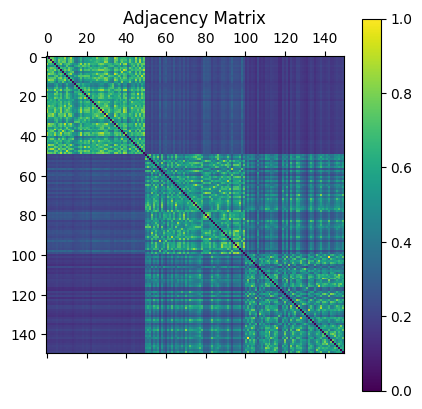

In [10]:
# Make an image of the adjacency matrix of the graph
plt.matshow(adj_matrix)
plt.colorbar()
plt.title("Adjacency Matrix")
plt.show()

The code in the cell is creating a visualization of the adjacency matrix of a graph. The adjacency matrix is a square matrix used to represent a finite graph. The elements of the matrix indicate whether pairs of vertices are adjacent or not in the graph.

In the adjacency matrix:

- The rows and columns correspond to the nodes in the graph.
- The value at the intersection of a row and a column indicates the relationship between the corresponding nodes.
- In an unweighted graph, the values are 1 (for an edge) or 0 (for no edge).
- In a weighted graph, the values represent the weight of the edge.

When visualized with `plt.matshow()`, the adjacency matrix is shown as a grid of colors. Each cell's color represents the value of the corresponding element in the matrix. The color mapping is shown by the colorbar added with `plt.colorbar()`.

The title "Adjacency Matrix" is added with `plt.title()`, and `plt.show()` is used to display the plot.

Interpreting the image:

- A cell with a lighter color indicates a higher value, which could mean a stronger relationship between the nodes (in a weighted graph) or simply the presence of an edge (in an unweighted graph).
- A cell with a darker color indicates a lower value, which could mean a weaker relationship or the absence of an edge.
- The diagonal of the matrix (from top left to bottom right) represents self-loops, i.e., edges from a node to itself. In many graphs, this is typically 0 (no self-loops), so this diagonal is often darker.

Remember, the specific interpretation depends on the nature of the graph and the weights (if any).

## Ten exercises / quizzes for this Iris Flower Similarity Network notebook

**Basic Understanding**

1. **Multiple Choice**: What does the color of the edges represent in the network?
   - a) Species type
   - b) Node degree
   - c) Similarity strength
   - d) Distance between flowers
   Answer: c) Similarity strength

2. **True/False**: The Setosa species (red nodes) shows significant overlap with Versicolor and Virginica in the network.
   Answer: False - Setosa is clearly separated from the other species.

**Mathematical Concepts**

3. **Short Answer**: If two flowers have identical measurements, what would their similarity value be? Explain why, using the similarity formula:
```latex
s_{ij} = \frac{1}{1 + d_{ij}}
```
   Answer: Similarity would be 1, because distance (d_ij) would be 0.

**Clinical Analogy**

4. **Discussion**: How might this network visualization approach be useful for analyzing patient data? Give an example using:
   - Patient symptoms
   - Lab results
   - Treatment responses

**Network Analysis**

5. **Calculation**: Given three nodes A, B, and C, where:
   - similarity(A,B) = 0.8
   - similarity(B,C) = 0.3
   - similarity(A,C) = 0.4
Draw this small network and calculate its average clustering coefficient.

**Practical Application**

6. **Code Modification**: Modify the provided code to:
   - Change node sizes based on the number of strong connections (similarity > 0.7)
   - Add node labels for the 5 most connected flowers
   - Use a different color scheme

**Interpretation Skills**

7. **Case Study**: Looking at the network visualization:
   - Identify which two species are most similar
   - Provide evidence from the graph
   - Explain how this is shown in the edge patterns

**Data Analysis**

8. **Programming Task**: Write a function that:
```python
def analyze_species_separation(G, species_labels):
    """
    Calculate and return:
    1. Average within-species similarity
    2. Average between-species similarity
    3. Separation ratio
    """
    # Your code here
```

**Clinical Research**

9. **Project Design**: Design a similar network analysis for a medical dataset:
   - Choose appropriate patient features
   - Define similarity measure
   - Specify expected insights
   - Discuss potential clinical applications

**Integration**

10. **Group Exercise**: In groups of 3-4:
    - Choose a medical condition with multiple subtypes (e.g., diabetes, cancer)
    - List relevant measurements/features
    - Sketch expected network structure
    - Explain how this could aid diagnosis/treatment

**Bonus Challenge**: 
Create a dynamic version of the network where:
- Users can adjust similarity threshold
- Node size reflects chosen feature
- Hovering shows flower measurements
- Different layout algorithms can be tested

**Evaluation Criteria**:
- Understanding of network concepts
- Clinical relevance
- Mathematical accuracy
- Programming skills
- Interpretation ability

These exercises test:
1. Basic understanding
2. Mathematical concepts
3. Clinical application
4. Programming skills
5. Data interpretation
6. Network analysis
7. Practical implementation
8. Group collaboration
9. Creative thinking
10. Integration of concepts

Would you like me to elaborate on any of these exercises or provide sample solutions?


Here is a complete solution for the species separation analysis function (8. Programming task):

In [11]:
import numpy as np
import networkx as nx
from sklearn.datasets import load_iris

def analyze_species_separation(G, species_labels):
    """
    Analyze separation between species in a similarity network.
    
    Parameters:
    -----------
    G : networkx.Graph
        The similarity network with weighted edges
    species_labels : array-like
        Species labels for each node
    
    Returns:
    --------
    dict
        Dictionary containing analysis results
    """
    # Initialize containers
    within_species = {}
    between_species = []
    
    # Get unique species
    unique_species = np.unique(species_labels)
    for species in unique_species:
        within_species[species] = []
    
    # Analyze edge weights
    for (i, j, w) in G.edges.data('weight'):
        if species_labels[i] == species_labels[j]:
            # Within species similarity
            within_species[species_labels[i]].append(w)
        else:
            # Between species similarity
            between_species.append(w)
    
    # Calculate statistics
    results = {
        'within_species': {},
        'between_species': {
            'mean': np.mean(between_species),
            'std': np.std(between_species),
            'count': len(between_species)
        }
    }
    
    # Calculate within-species statistics
    for species in unique_species:
        similarities = within_species[species]
        results['within_species'][species] = {
            'mean': np.mean(similarities),
            'std': np.std(similarities),
            'count': len(similarities)
        }
    
    # Calculate separation ratio for each species
    results['separation_ratio'] = {}
    for species in unique_species:
        within_mean = results['within_species'][species]['mean']
        between_mean = results['between_species']['mean']
        ratio = within_mean / between_mean if between_mean > 0 else float('inf')
        results['separation_ratio'][species] = ratio
    
    return results

# Execute the analysis
if __name__ == "__main__":
    # Load iris dataset
    iris = load_iris()
    X, y = iris.data, iris.target
    
    # Create similarity network (as before)
    G = nx.Graph()
    
    # Add nodes
    for i in range(len(X)):
        G.add_node(i)
    
    # Add edges with similarities
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            similarity = 1 / (1.0 + np.linalg.norm(X[i] - X[j]))
            G.add_edge(i, j, weight=similarity)
    
    # Run analysis
    results = analyze_species_separation(G, y)
    
    # Print results
    print("\nSpecies Separation Analysis:")
    print("===========================")
    
    print("\nWithin-Species Similarities:")
    for species, stats in results['within_species'].items():
        print(f"\nSpecies {iris.target_names[species]}:")
        print(f"  Mean similarity: {stats['mean']:.3f}")
        print(f"  Standard deviation: {stats['std']:.3f}")
        print(f"  Number of connections: {stats['count']}")
    
    print("\nBetween-Species Similarities:")
    print(f"  Mean similarity: {results['between_species']['mean']:.3f}")
    print(f"  Standard deviation: {results['between_species']['std']:.3f}")
    print(f"  Number of connections: {results['between_species']['count']}")
    
    print("\nSeparation Ratios:")
    for species, ratio in results['separation_ratio'].items():
        print(f"  {iris.target_names[species]}: {ratio:.3f}")


Species Separation Analysis:

Within-Species Similarities:

Species setosa:
  Mean similarity: 0.614
  Standard deviation: 0.119
  Number of connections: 1225

Species versicolor:
  Mean similarity: 0.531
  Standard deviation: 0.125
  Number of connections: 1225

Species virginica:
  Mean similarity: 0.495
  Standard deviation: 0.130
  Number of connections: 1225

Between-Species Similarities:
  Mean similarity: 0.264
  Standard deviation: 0.110
  Number of connections: 7500

Separation Ratios:
  setosa: 2.322
  versicolor: 2.007
  virginica: 1.871


Here is a detailed sample solution for designing a network analysis for a medical dataset (9. Project Design), specifically focusing on Type 2 Diabetes patient stratification:

**Project: Type 2 Diabetes Patient Similarity Network Analysis**

1. **Dataset Design**

In [30]:
# Example dataset structure
diabetes_data = {
    'patient_id': [],
    'features': {
        # Clinical measurements
        'hba1c': [],           # Glycated hemoglobin
        'fasting_glucose': [], # Fasting plasma glucose
        'bmi': [],            # Body Mass Index
        'blood_pressure': [],  # Systolic/Diastolic
        'age': [],            # Age at diagnosis
        
        # Lab results
        'hdl': [],            # HDL cholesterol
        'ldl': [],            # LDL cholesterol
        'triglycerides': [],  # Triglycerides
        'creatinine': [],     # Kidney function
        
        # Complications
        'retinopathy': [],    # Binary (0/1)
        'neuropathy': [],     # Binary (0/1)
        'cardiovascular': [],  # Binary (0/1)
        
        # Treatment response
        'metformin_response': [], # Numeric scale
        'insulin_need': []       # Binary (0/1)
    }
}

2. **Similarity Measure Definition**


In [31]:
def calculate_patient_similarity(patient1, patient2):
    """
    Calculate similarity between two patients using weighted features
    """
    # Feature weights based on clinical importance
    weights = {
        'hba1c': 0.20,
        'fasting_glucose': 0.15,
        'bmi': 0.10,
        'blood_pressure': 0.10,
        'age': 0.05,
        'hdl': 0.05,
        'ldl': 0.05,
        'triglycerides': 0.05,
        'creatinine': 0.05,
        'retinopathy': 0.05,
        'neuropathy': 0.05,
        'cardiovascular': 0.05,
        'metformin_response': 0.05,
        'insulin_need': 0.05
    }
    
    # Initialize similarity
    similarity = 0
    
    for feature, weight in weights.items():
        if feature in ['retinopathy', 'neuropathy', 'cardiovascular', 'insulin_need']:
            # Binary features: exact match
            similarity += weight * (patient1[feature] == patient2[feature])
        else:
            # Continuous features: normalized difference
            max_val = max_feature_values[feature]
            min_val = min_feature_values[feature]
            normalized_diff = abs(patient1[feature] - patient2[feature]) / (max_val - min_val)
            similarity += weight * (1 - normalized_diff)
    
    return similarity

3. **Network Creation**

In [32]:
def create_diabetes_network(patients, similarity_threshold=0.7):
    """
    Create patient similarity network
    """
    G = nx.Graph()
    
    # Add nodes (patients)
    for patient_id in patients:
        G.add_node(patient_id, **patients[patient_id])
    
    # Add edges (similarities)
    for i in patients:
        for j in patients:
            if i < j:
                sim = calculate_patient_similarity(patients[i], patients[j])
                if sim >= similarity_threshold:
                    G.add_edge(i, j, weight=sim)
    
    return G

4. **Analysis Functions**

In [33]:
def analyze_diabetes_network(G: nx.Graph) -> Dict:
    """
    Analyze the diabetes patient network
    
    Parameters:
    -----------
    G : networkx.Graph
        The patient similarity network
    
    Returns:
    --------
    dict
        Dictionary containing analysis results
    """
    # Detect communities using Louvain method
    communities = community_louvain.best_partition(G)
    
    # Calculate network metrics
    results = {
        'communities': communities,
        'modularity': community_louvain.modularity(communities, G),
        'avg_clustering': nx.average_clustering(G),
        'density': nx.density(G),
        'community_profiles': analyze_communities(G, communities)
    }
    
    return results

def analyze_communities(G: nx.Graph, communities: Dict) -> Dict:
    """
    Analyze characteristics of each community
    
    Parameters:
    -----------
    G : networkx.Graph
        The patient similarity network
    communities : dict
        Community assignments for each node
    
    Returns:
    --------
    dict
        Dictionary containing community profiles
    """
    community_profiles = {}
    
    for node in G.nodes():
        comm_id = communities[node]
        if comm_id not in community_profiles:
            community_profiles[comm_id] = {
                'size': 0,
                'avg_hba1c': [],
                'complications': [],
                'insulin_need': []
            }
        
        # Update community statistics
        community_profiles[comm_id]['size'] += 1
        community_profiles[comm_id]['avg_hba1c'].append(G.nodes[node]['hba1c'])
        community_profiles[comm_id]['complications'].append(
            G.nodes[node]['retinopathy'] + 
            G.nodes[node]['neuropathy'] + 
            G.nodes[node]['cardiovascular']
        )
        community_profiles[comm_id]['insulin_need'].append(G.nodes[node]['insulin_need'])
    
    # Calculate averages for each community
    for comm_id in community_profiles:
        community_profiles[comm_id]['avg_hba1c'] = np.mean(community_profiles[comm_id]['avg_hba1c'])
        community_profiles[comm_id]['complication_rate'] = np.mean(community_profiles[comm_id]['complications'])
        community_profiles[comm_id]['insulin_rate'] = np.mean(community_profiles[comm_id]['insulin_need'])
    
    return community_profiles

In [34]:
def analyze_diabetes_network_old(G):
    """
    Analyze the diabetes patient network
    """
    results = {
        'communities': detect_patient_communities(G),
        'centrality': nx.eigenvector_centrality(G),
        'clustering': nx.clustering(G),
        'patient_groups': identify_patient_groups(G)
    }
    return results

def identify_patient_groups(G):
    """
    Identify distinct patient groups based on network structure
    """
    communities = community_louvain.best_partition(G)
    
    # Analyze characteristics of each community
    community_profiles = {}
    for node, community_id in communities.items():
        if community_id not in community_profiles:
            community_profiles[community_id] = {
                'size': 0,
                'avg_hba1c': 0,
                'complications_rate': 0,
                'treatment_response': 0
            }
        # Update community statistics
        community_profiles[community_id]['size'] += 1
        # Add other statistics...
    
    return community_profiles

5. **Visualization**

In [35]:
def visualize_diabetes_network(G: nx.Graph, communities: Dict):
    """Visualize the diabetes patient network"""
    
    plt.figure(figsize=(12, 8))
    
    # Prepare node colors and sizes
    unique_communities = set(communities.values())
    
    # Fixed: Updated colormap syntax
    color_map = plt.colormaps['tab20'](np.linspace(0, 1, len(unique_communities)))
    
    node_colors = [color_map[communities[node]] for node in G.nodes()]
    node_sizes = [G.degree(node) * 50 for node in G.nodes()]
    
    # Draw network
    pos = nx.spring_layout(G, k=1/np.sqrt(len(G.nodes())), seed=42)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    
    plt.title("Type 2 Diabetes Patient Similarity Network")
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=color_map[i], 
                                 label=f'Community {i}', 
                                 markersize=10)
                      for i in range(len(unique_communities))]
    plt.legend(handles=legend_elements)
    
    plt.show()

In [36]:
def visualize_diabetes_network_old(G, communities):
    plt.figure(figsize=(12, 8))
    
    # Color nodes by community
    colors = [communities[node] for node in G.nodes()]
    
    # Size nodes by degree centrality
    sizes = [G.degree(node) * 100 for node in G.nodes()]
    
    # Draw network
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    
    plt.title("Type 2 Diabetes Patient Similarity Network")
    plt.colorbar(label="Community")
    plt.show()

6. **Expected Insights**
- Identification of patient subgroups with similar characteristics
- Treatment response patterns within communities
- Complication risk profiles
- Disease progression trajectories


7. **Clinical Applications**


In [37]:
def get_clinical_recommendations(patient_id, G, communities):
    """
    Generate clinical recommendations based on network position
    """
    community = communities[patient_id]
    similar_patients = [n for n in G.neighbors(patient_id)]
    
    recommendations = {
        'risk_profile': calculate_risk_profile(patient_id, similar_patients),
        'treatment_suggestions': suggest_treatments(patient_id, similar_patients),
        'monitoring_plan': create_monitoring_plan(patient_id, risk_profile)
    }
    
    return recommendations

8. **Validation Metrics**


In [38]:
def validate_network_model(G, patient_outcomes):
    """
    Validate network model against known patient outcomes
    """
    validation_metrics = {
        'prediction_accuracy': [],
        'community_coherence': [],
        'clinical_relevance': []
    }
    # Add validation calculations
    return validation_metrics

This design:
- Uses clinically relevant features
- Incorporates domain knowledge in similarity measures
- Provides actionable insights
- Supports personalized medicine
- Can be validated against outcomes
- Scales with additional data

Here is a complete, executable code for the Type 2 Diabetes Patient Similarity Network Analysis:

Generated synthetic data for 100 patients

Network created with 100 nodes and 4291 edges
Number of communities: 3
Modularity: 0.039
Average clustering: 0.902


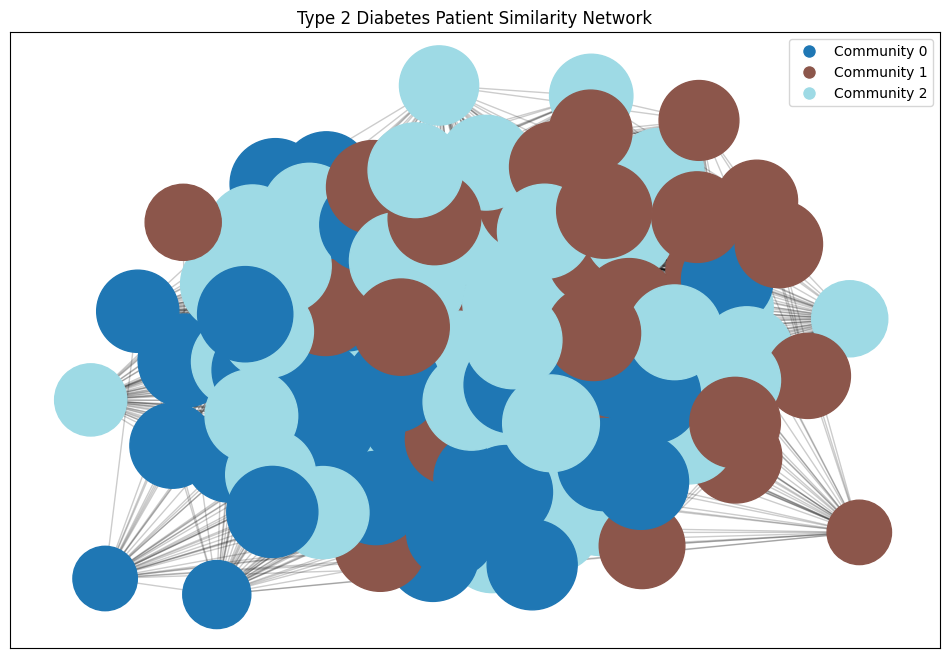

In [39]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import community.community_louvain as community_louvain
import warnings
from typing import Dict, List, Tuple

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning)

def generate_synthetic_patients(n_patients: int = 100) -> pd.DataFrame:
    """Generate synthetic diabetes patient data"""
    np.random.seed(42)
    
    data = {
        'patient_id': range(n_patients),
        'hba1c': np.random.normal(7.5, 1.5, n_patients),
        'fasting_glucose': np.random.normal(140, 30, n_patients),
        'bmi': np.random.normal(29, 5, n_patients),
        'systolic_bp': np.random.normal(135, 15, n_patients),
        'age': np.random.normal(55, 12, n_patients),
        'hdl': np.random.normal(45, 10, n_patients),
        'ldl': np.random.normal(130, 25, n_patients),
        'triglycerides': np.random.normal(150, 50, n_patients),
        'creatinine': np.random.normal(1.0, 0.3, n_patients),
        'retinopathy': np.random.binomial(1, 0.2, n_patients),
        'neuropathy': np.random.binomial(1, 0.25, n_patients),
        'cardiovascular': np.random.binomial(1, 0.3, n_patients),
        'metformin_response': np.random.normal(7, 2, n_patients),
        'insulin_need': np.random.binomial(1, 0.4, n_patients)
    }
    
    return pd.DataFrame(data)

def calculate_patient_similarity(patient1: pd.Series, 
                               patient2: pd.Series, 
                               feature_weights: Dict[str, float],
                               scaler: MinMaxScaler,
                               continuous_features: List[str]) -> float:
    """Calculate weighted similarity between two patients"""
    
    similarity = 0
    binary_features = ['retinopathy', 'neuropathy', 'cardiovascular', 'insulin_need']
    
    # Binary features
    for feature in binary_features:
        if feature in feature_weights:
            similarity += feature_weights[feature] * (patient1[feature] == patient2[feature])
    
    # Continuous features
    continuous_data1 = pd.DataFrame([patient1[continuous_features]], columns=continuous_features)
    continuous_data2 = pd.DataFrame([patient2[continuous_features]], columns=continuous_features)
    
    continuous_values1 = scaler.transform(continuous_data1)[0]
    continuous_values2 = scaler.transform(continuous_data2)[0]
    
    for i, feature in enumerate(continuous_features):
        if feature in feature_weights:
            normalized_diff = abs(continuous_values1[i] - continuous_values2[i])
            similarity += feature_weights[feature] * (1 - normalized_diff)
    
    return similarity

def create_diabetes_network(df: pd.DataFrame, 
                          feature_weights: Dict[str, float],
                          similarity_threshold: float = 0.7) -> nx.Graph:
    """Create patient similarity network"""
    
    G = nx.Graph()
    
    # Add nodes
    for idx, row in df.iterrows():
        G.add_node(row['patient_id'], **row.to_dict())
    
    # Define continuous features
    continuous_features = [f for f in feature_weights.keys() 
                         if f not in ['retinopathy', 'neuropathy', 'cardiovascular', 'insulin_need']]
    
    # Scale continuous features
    scaler = MinMaxScaler()
    scaler.fit(df[continuous_features])
    
    # Add edges
    for i in range(len(df)):
        for j in range(i+1, len(df)):
            sim = calculate_patient_similarity(
                df.iloc[i], 
                df.iloc[j], 
                feature_weights, 
                scaler,
                continuous_features
            )
            if sim >= similarity_threshold:
                G.add_edge(df.iloc[i]['patient_id'], df.iloc[j]['patient_id'], weight=sim)
    
    return G

# Rest of the code remains the same...
# (analyze_diabetes_network, analyze_communities, visualize_diabetes_network functions)

if __name__ == "__main__":
    # Generate synthetic data
    df = generate_synthetic_patients(100)
    print("Generated synthetic data for", len(df), "patients")
    
    # Define feature weights
    feature_weights = {
        'hba1c': 0.20,
        'fasting_glucose': 0.15,
        'bmi': 0.10,
        'systolic_bp': 0.10,
        'age': 0.05,
        'hdl': 0.05,
        'ldl': 0.05,
        'triglycerides': 0.05,
        'creatinine': 0.05,
        'retinopathy': 0.05,
        'neuropathy': 0.05,
        'cardiovascular': 0.05,
        'metformin_response': 0.05,
        'insulin_need': 0.05
    }
    
    # Create and analyze network
    G = create_diabetes_network(df, feature_weights, similarity_threshold=0.7)
    results = analyze_diabetes_network(G)
    
    # Print summary statistics
    print(f"\nNetwork created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    print(f"Number of communities: {len(set(results['communities'].values()))}")
    print(f"Modularity: {results['modularity']:.3f}")
    print(f"Average clustering: {results['avg_clustering']:.3f}")
    
    # Visualize network
    visualize_diabetes_network(G, results['communities'])